In [5]:
from scipy.ndimage import rotate
import pandas as pd 
import numpy as np 
import math
# libraries for data visualization
import matplotlib.pyplot as plt
# libraries for model selection
import xgboost as xgb
# libraries for model evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
#library to read matlab files
from scipy.io import loadmat
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV


<h1>Load and Parse Data</h1>

In [6]:
#Import the MNIST.mat file
mat_data = loadmat('/Users/deep/Desktop/ML_Project-1/MNIST.mat')
# Print the keys of the MATLAB file to understand what data it contains
print(mat_data.keys())

pixel_features = mat_data['train_fea']
pixel_labels = mat_data['train_gnd'].ravel()

pixel_test_features = mat_data['test_fea']
pixel_test_labels = mat_data['test_gnd'].ravel()

#Normalize the pixel features
pixel_features = pixel_features/255
pixel_test_features = pixel_test_features/255


dict_keys(['__header__', '__version__', '__globals__', 'train_fea', 'train_gnd', 'test_fea', 'test_gnd'])


<h1>Encode Labels <h1>

In [7]:
# Encode labels to be in [0, num_class) so it will start from 0 instead of 1
label_encoder = LabelEncoder()
pixel_labels = label_encoder.fit_transform(pixel_labels)
pixel_test_labels = label_encoder.transform(pixel_test_labels)

<h1>Visualize Raw Data<h1>

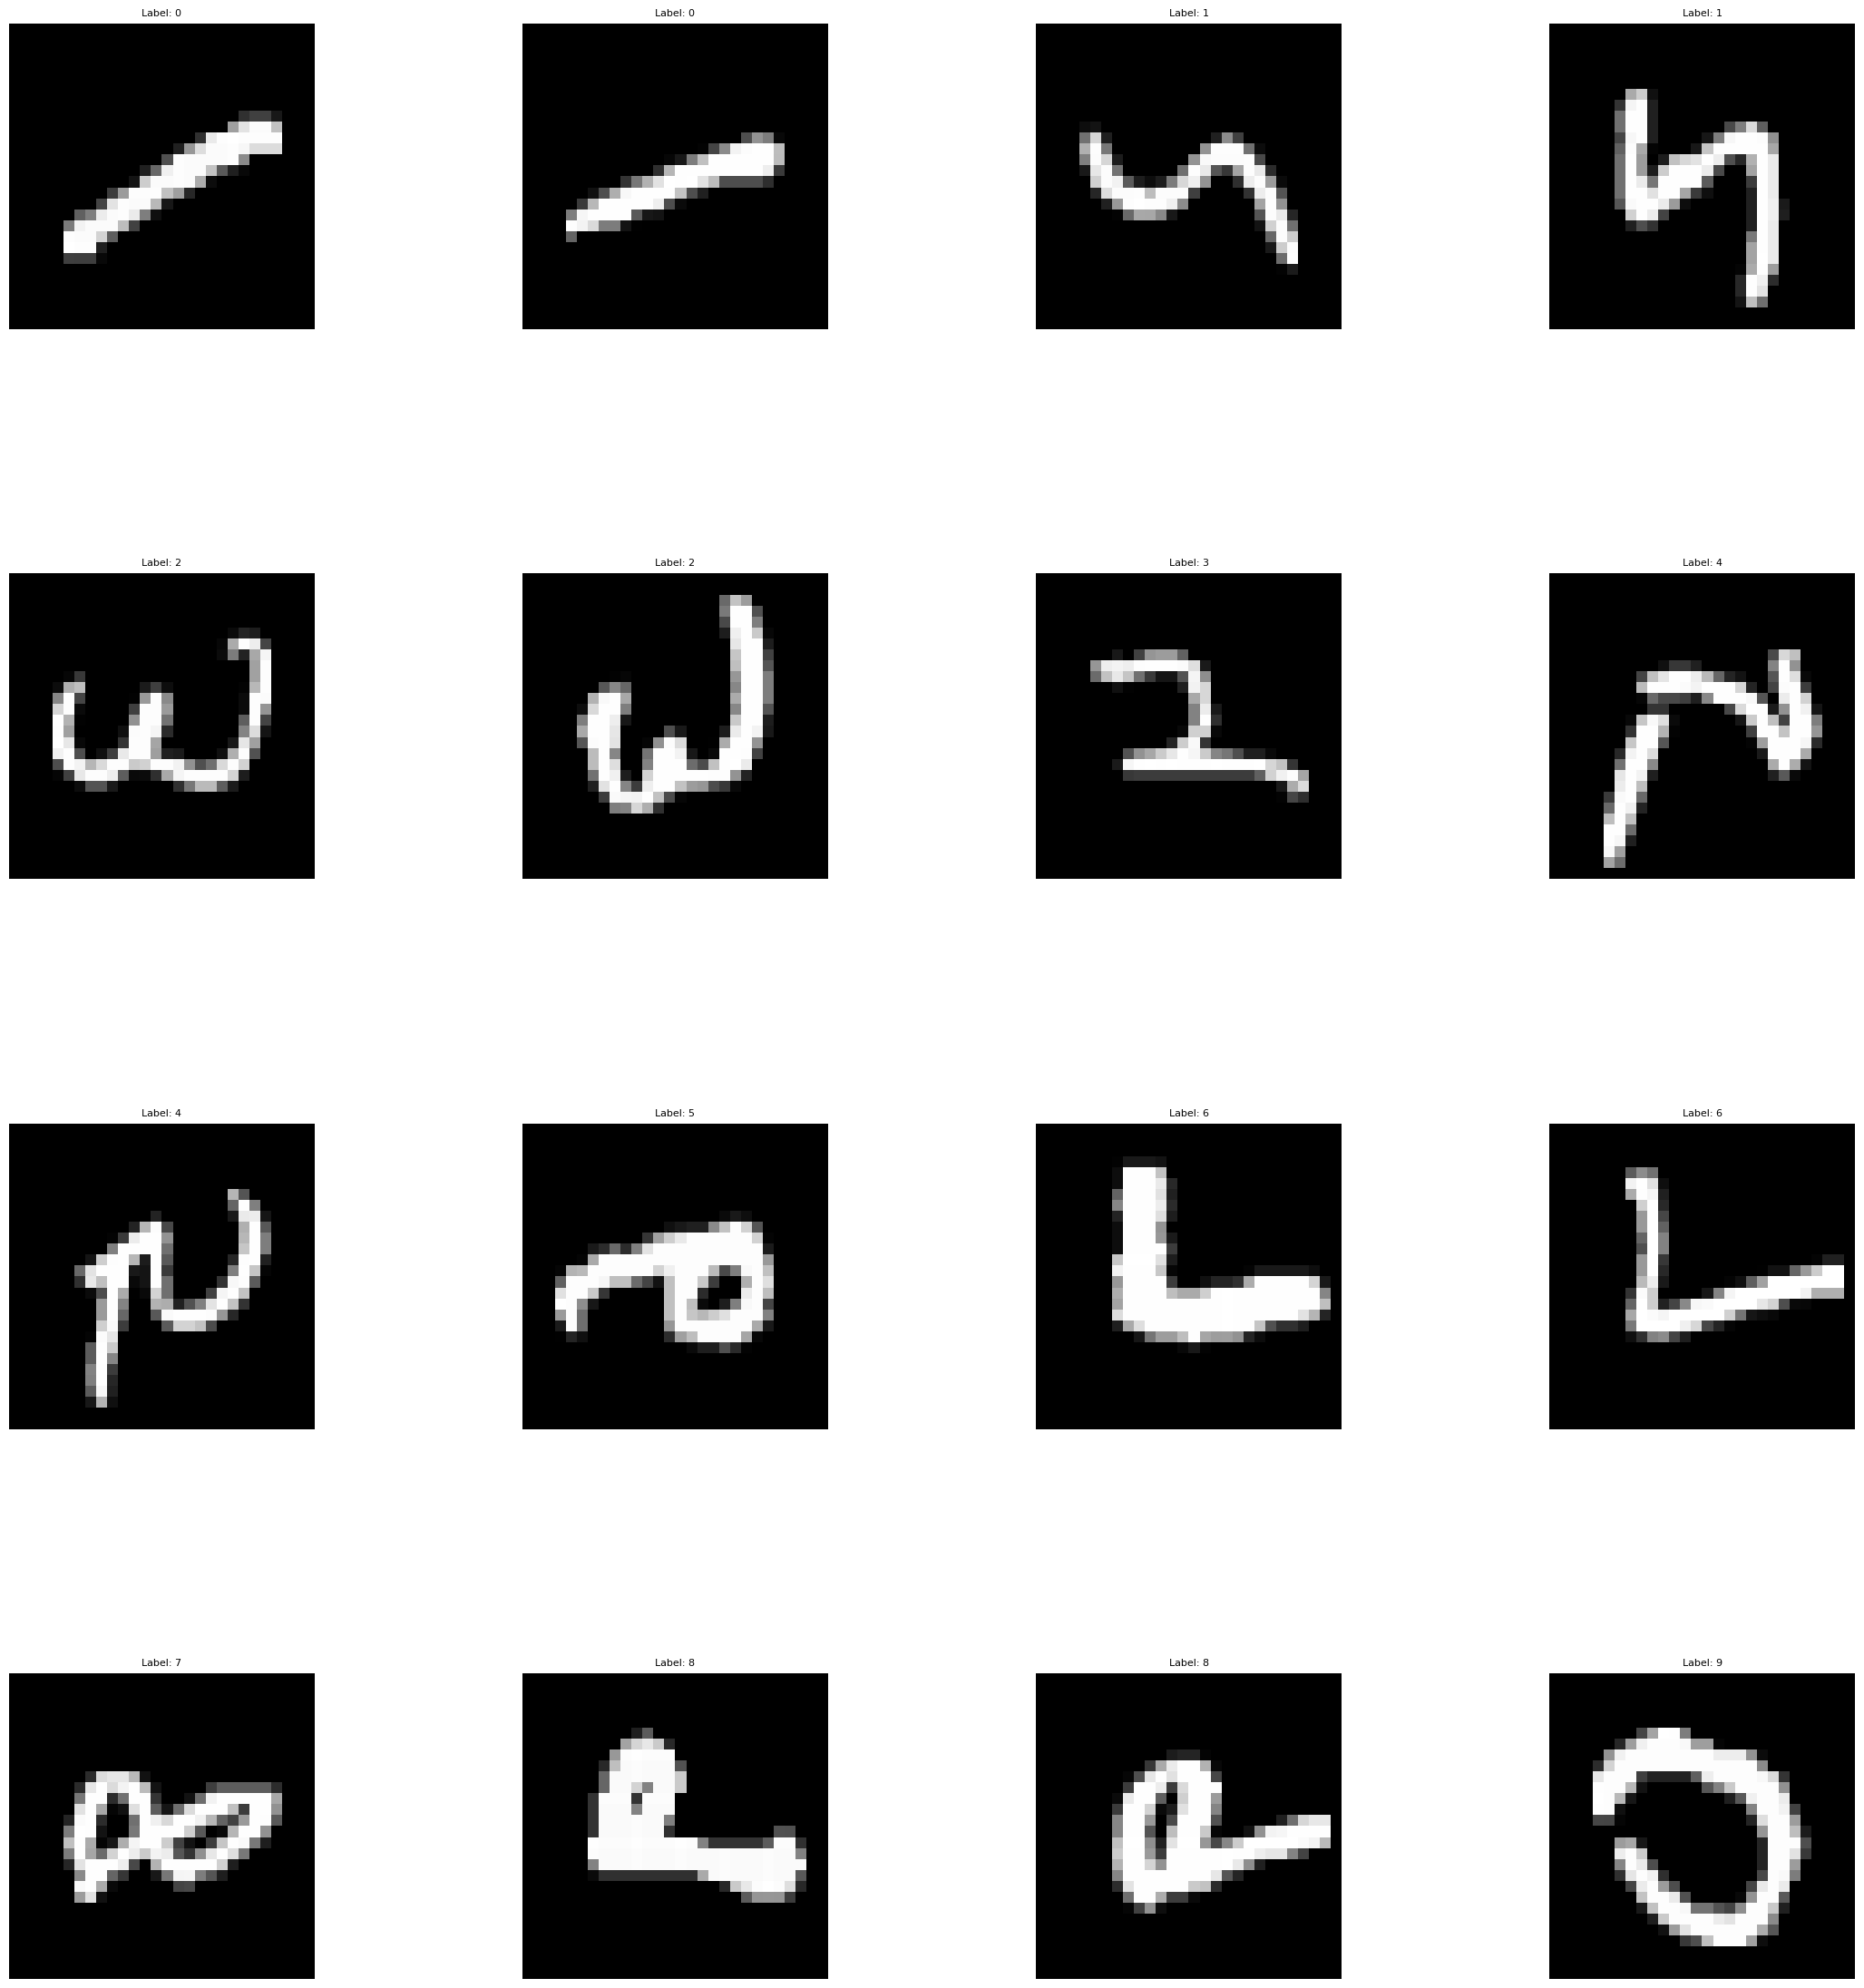

In [8]:
# add the number of images gonna be printed if we want every image at the 3750 iteration 
num_images = len(pixel_features) // 3750

# Matplot is used to render the image 
fig, axes = plt.subplots(4, 4, figsize=(28, 28))
axes = axes.ravel()  # Flatten the 28x28 matrix into an array of 100 subplots

# Loop through subplots and add images
for i in range(num_images):
    idx = i * 3750 # 3750 is the number of images in each iteration
    
    if idx < 60000:
        image = pixel_features[idx].reshape(28, 28)  # Assuming the images are 28x28
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f"Label: {pixel_labels[idx]}", fontsize=8)
        plt.subplots_adjust(hspace=0.8)
        axes[i].axis('off')
    


plt.show()

<h1> Augment Data <h1>

In [9]:
# Assuming pixel_features is a numpy array with each row as a flattened image
# Reshape it to a 3D array: number of images x width x height, -1 means all of the images
image_data_reshaped = pixel_features.reshape(-1, 28, 28)
image_data_reshaped2 = pixel_test_features.reshape(-1, 28, 28)
# Rotated images by 180 degrees
train_features_2D = np.rot90(image_data_reshaped, k=3, axes=(1, 2))
train_features_2D2 = np.rot90(image_data_reshaped2, k=3, axes=(1, 2))
#flip the images to the left
train_features_2D = np.flip(train_features_2D, axis=(2))
train_features_2D2 = np.flip(train_features_2D2, axis=(2))
# Flatten the images again for XGBoost:
flattened_images = train_features_2D.reshape(pixel_features.shape)
flattened_images2 = train_features_2D2.reshape(pixel_test_features.shape)

# Generate shuffled indices
shuffled_indices = np.random.permutation(flattened_images.shape[0])
shuffled_indices2 = np.random.permutation(flattened_images2.shape[0])

# Shuffle features and labels correspondingly
train_features_shuffled = flattened_images[shuffled_indices]
train_labels_shuffled = pixel_labels[shuffled_indices]

train_features_shuffled2 = flattened_images2[shuffled_indices2]
train_labels_shuffled2 = pixel_test_labels[shuffled_indices2]

# training Data
rotated_images = train_features_shuffled
rotated_labels = train_labels_shuffled

# testing Data
rotated_test_images = train_features_shuffled2
rotated_test_labels = train_labels_shuffled2


print(rotated_images.shape)
print(rotated_labels.shape)
print(rotated_test_images.shape)
print(rotated_test_labels.shape)


(60000, 784)
(60000,)
(10000, 784)
(10000,)


<h1> Visualization of Augmented Training Data </h1>

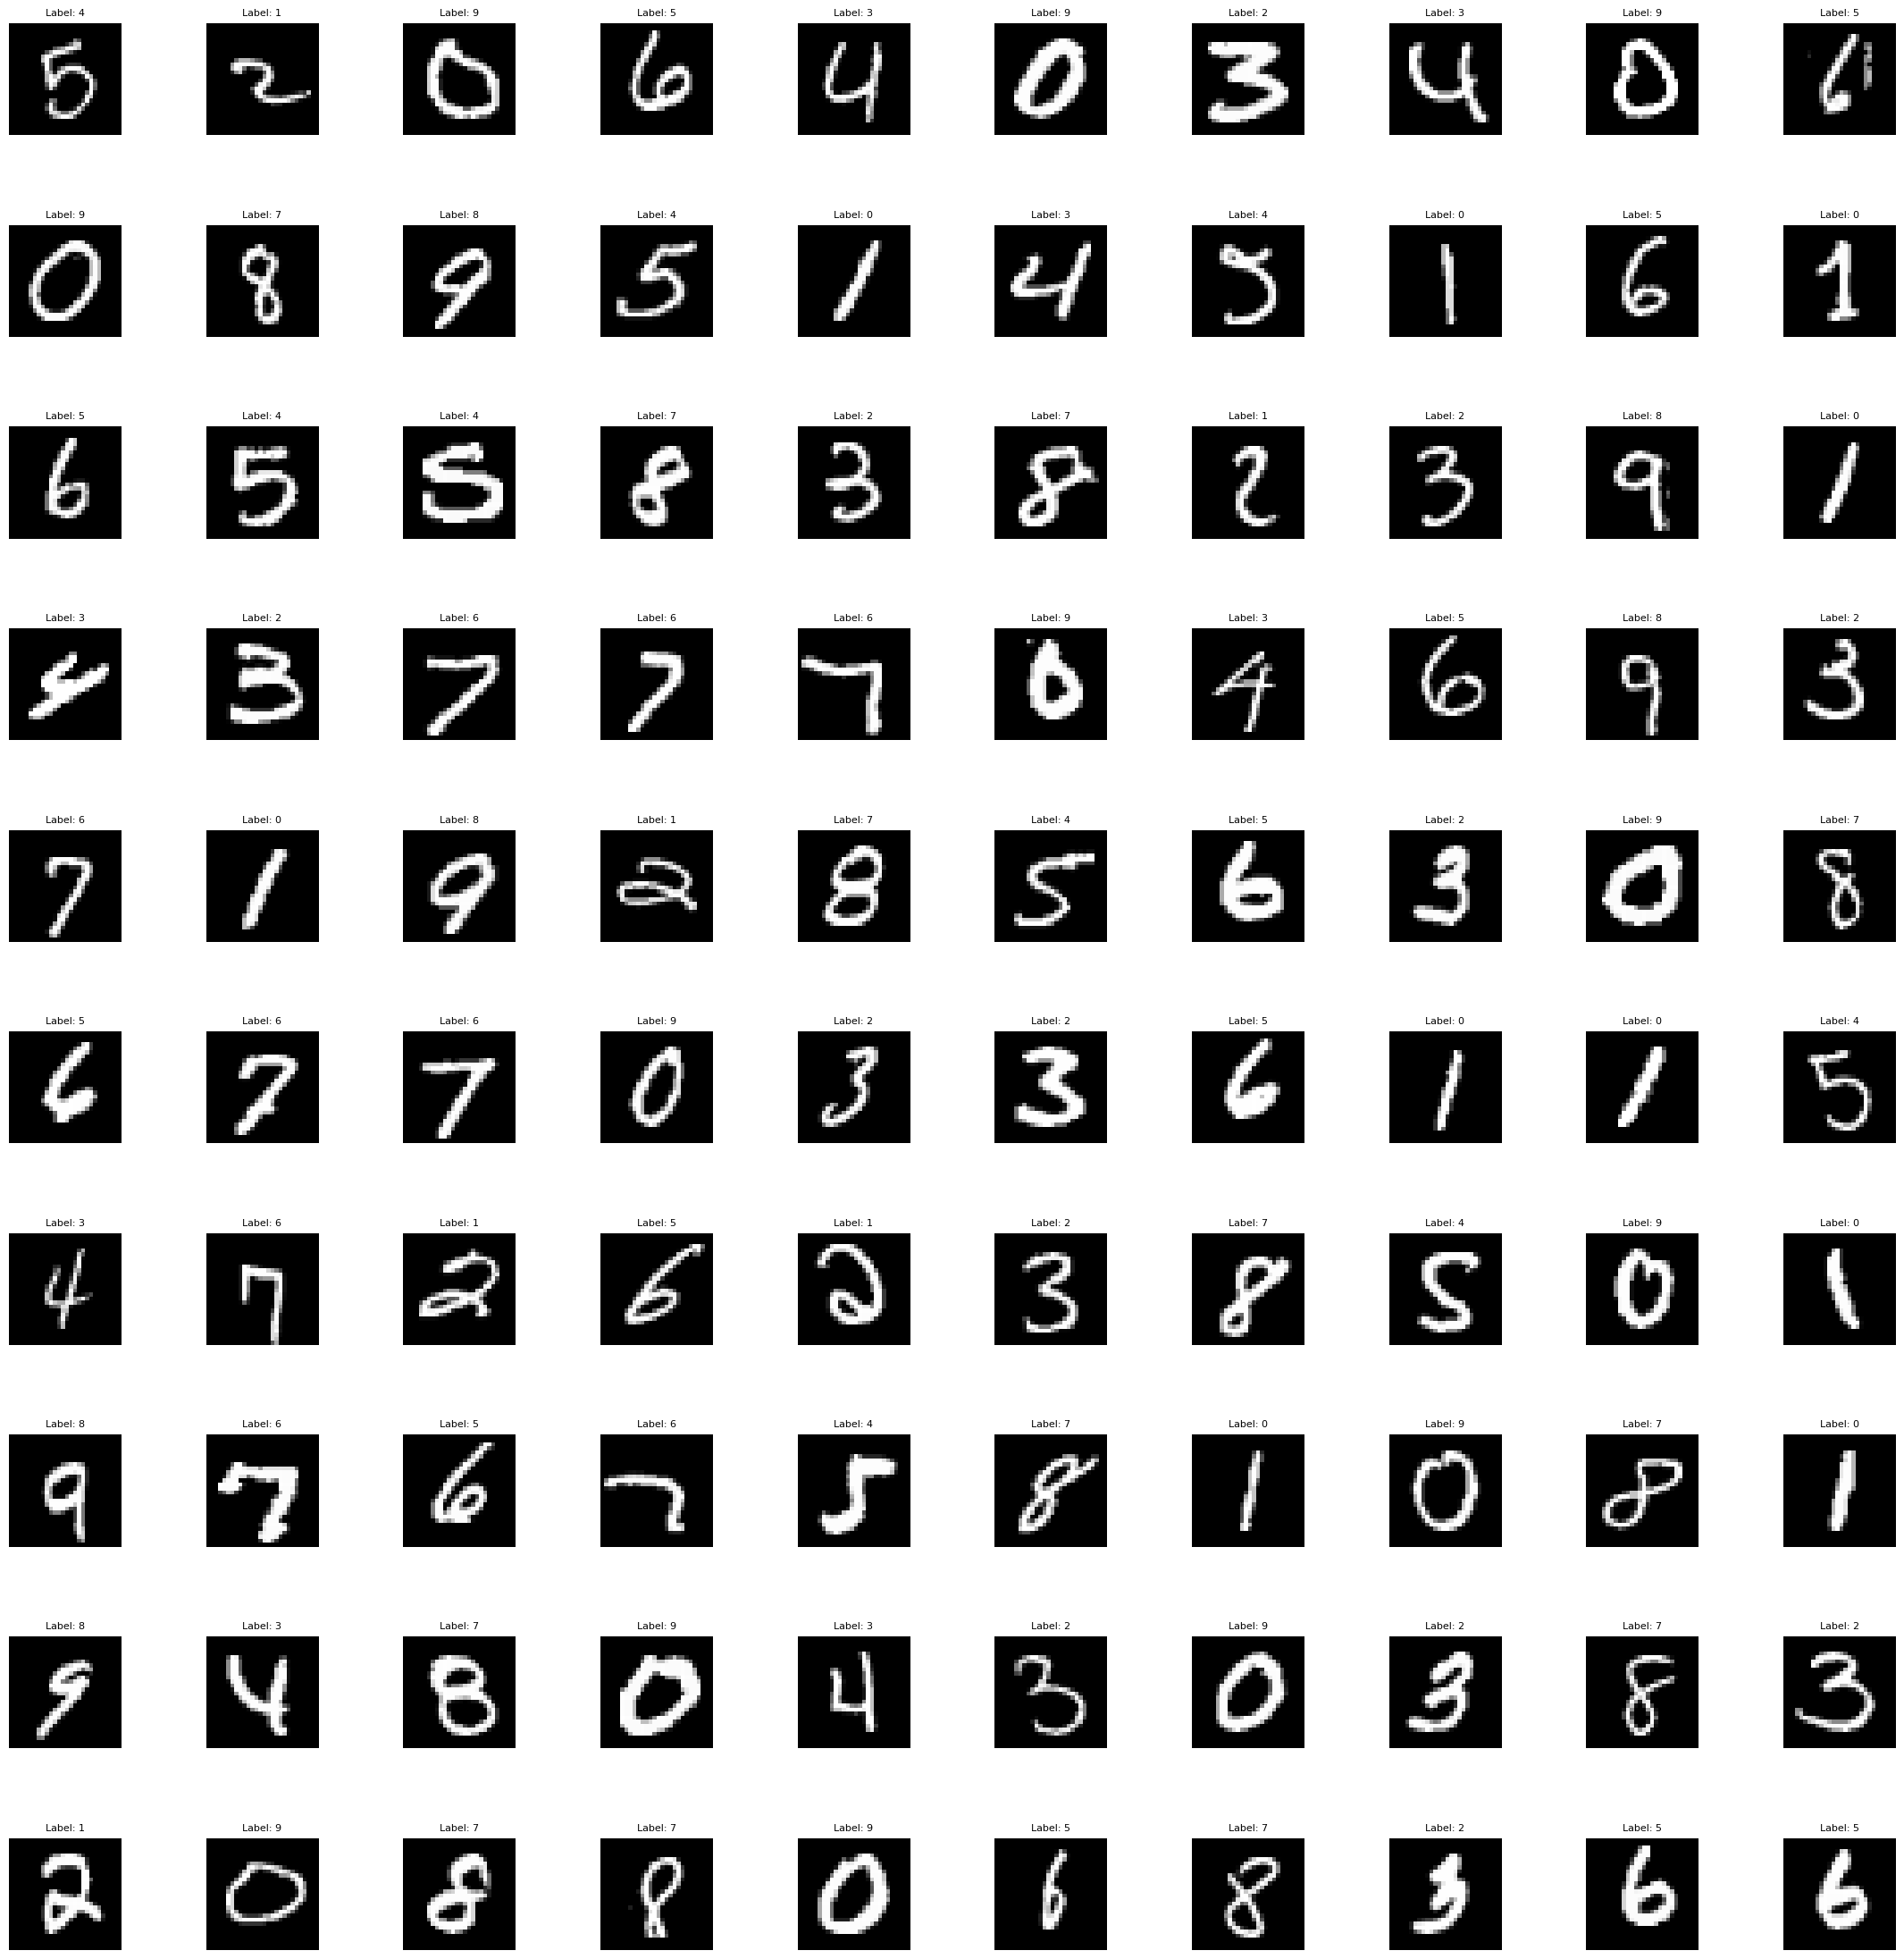

In [10]:
fig, axes = plt.subplots(10, 10, figsize=(28, 28))
axes = axes.ravel()  # Flatten the 10x10 matrix into an array of 100 subplots

# Loop through subplots and add images
for i in range(100):
    image = rotated_images[i].reshape(28, 28)  # Assuming the images are 10x10
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Label: {rotated_labels[i]}", fontsize=8)
    plt.subplots_adjust(hspace=0.8)
    axes[i].axis('off')

plt.show()

<h1> Visualization of Augmented Testing Data </h1>

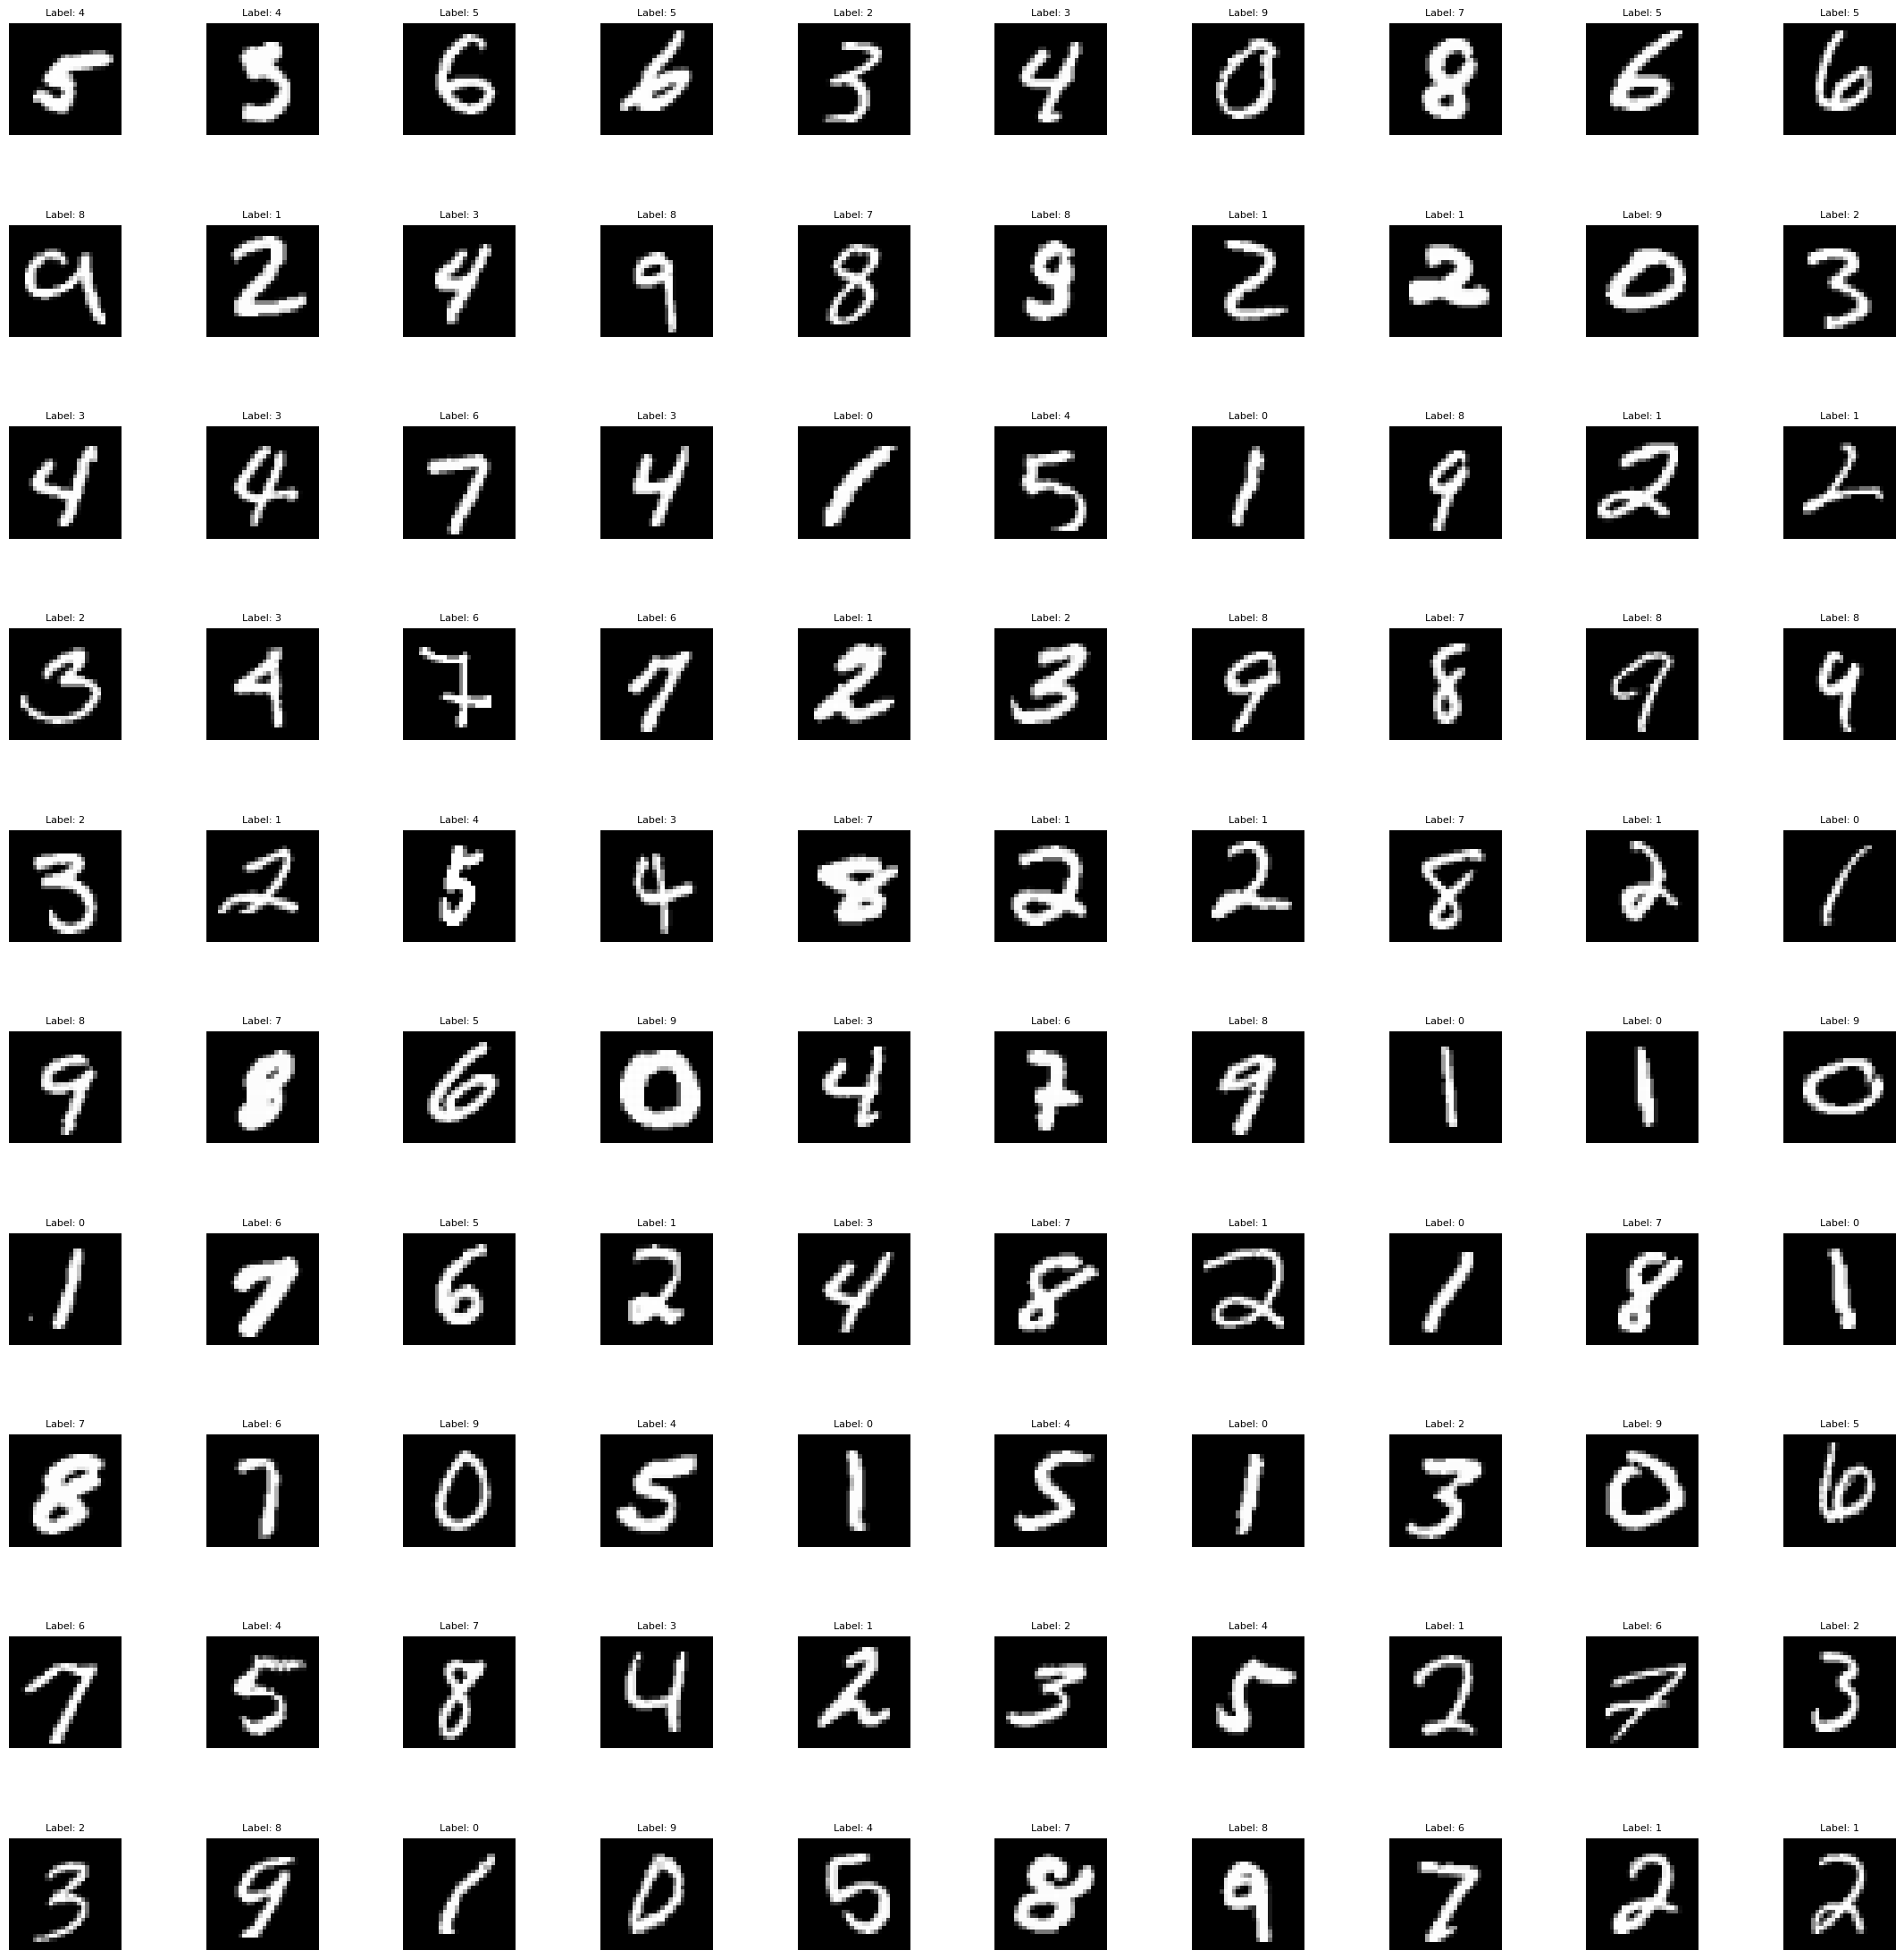

In [11]:

fig, axes = plt.subplots(10, 10, figsize=(28, 28))
axes = axes.ravel()  # Flatten the 10x10 matrix into an array of 100 subplots

# Loop through subplots and add images
for i in range(100):
    image = rotated_test_images[i].reshape(28, 28)  # Assuming the images are 10x10
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Label: {rotated_test_labels[i]}", fontsize=8)
    plt.subplots_adjust(hspace=0.8)
    axes[i].axis('off')

plt.show()

<h1>Split Data: Test = Test, Validation<h1>

In [12]:
#splitting the data into train and validation


pixel_train_features = rotated_images[:48000]
pixel_train_labels = rotated_labels[:48000]

pixel_val_features = rotated_images[48000:]
pixel_val_labels = rotated_labels[48000:]


print(pixel_train_features.shape)
print(pixel_train_labels.shape)
print(pixel_val_features.shape)
print(pixel_val_labels.shape)

(48000, 784)
(48000,)
(12000, 784)
(12000,)


<h1> Xgboost <h1>

In [13]:

#Convert the data into DMatrix format
pixel_train = xgb.DMatrix(pixel_train_features, label=pixel_train_labels)
pixel_val = xgb.DMatrix(pixel_val_features, label=pixel_val_labels)
pixel_test = xgb.DMatrix(rotated_test_images, label=rotated_test_labels)
print(rotated_test_labels.shape)

(10000,)


<h1> Parameters <h1>

In [14]:

# Set the parameters for the xgboost
params = {
    'num_class': 10,
    'max_depth': 5,
    'eta': 0.5,
    'eval_metric': 'mlogloss',
    'objective': 'multi:softmax',  # Ensure you're using the softmax objective
}



In [15]:

# To watch performance, you can set the evals parameter with a list of pairs (DMatrix, name)
eval_set = [(pixel_train, 'train'), (pixel_val, 'validate')]
evals_result = {}  # to store evaluation results for plotting
early_stop = 10 # stop if 10 consequent rounds without decrease of error

# Number of training rounds
num_rounds = 200

# Train the model
model = xgb.train(params, pixel_train, num_rounds, evals=eval_set, early_stopping_rounds=early_stop, evals_result=evals_result)

[0]	train-mlogloss:1.04310	validate-mlogloss:1.07029
[1]	train-mlogloss:0.74693	validate-mlogloss:0.78285
[2]	train-mlogloss:0.57430	validate-mlogloss:0.61692
[3]	train-mlogloss:0.45151	validate-mlogloss:0.49803
[4]	train-mlogloss:0.36585	validate-mlogloss:0.41661
[5]	train-mlogloss:0.30459	validate-mlogloss:0.35987
[6]	train-mlogloss:0.25891	validate-mlogloss:0.31689
[7]	train-mlogloss:0.22488	validate-mlogloss:0.28631
[8]	train-mlogloss:0.19513	validate-mlogloss:0.25898
[9]	train-mlogloss:0.17088	validate-mlogloss:0.23771
[10]	train-mlogloss:0.15049	validate-mlogloss:0.21911
[11]	train-mlogloss:0.13458	validate-mlogloss:0.20598
[12]	train-mlogloss:0.12034	validate-mlogloss:0.19254
[13]	train-mlogloss:0.10893	validate-mlogloss:0.18287
[14]	train-mlogloss:0.09774	validate-mlogloss:0.17327
[15]	train-mlogloss:0.09027	validate-mlogloss:0.16751
[16]	train-mlogloss:0.08314	validate-mlogloss:0.16157
[17]	train-mlogloss:0.07538	validate-mlogloss:0.15557
[18]	train-mlogloss:0.06921	validate-m

In [16]:
# Predict the labels of the test set
preds = model.predict(pixel_test)

# Calculate accuracy
accuracy = accuracy_score(rotated_test_labels, preds)
print(f"Pixel Features - Accuracy: {accuracy * 100}%")
#97.83%
#Accuracy: 97.59%

Pixel Features - Accuracy: 97.82%


<h1>Loss Evaluation <h1>

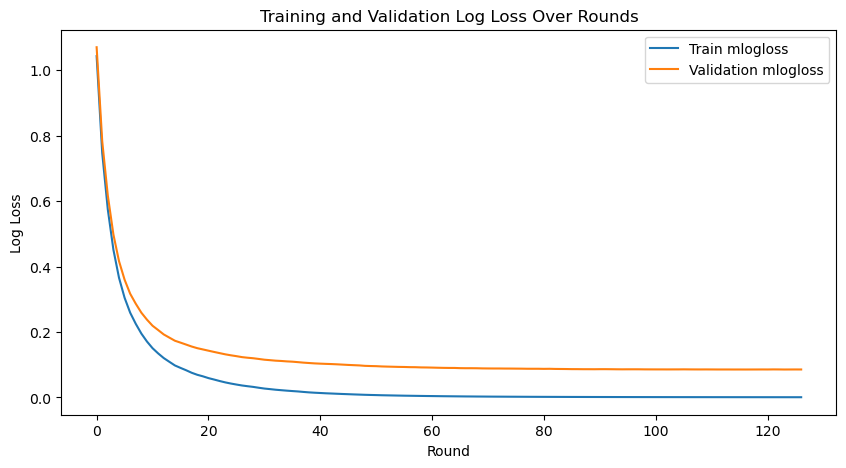

In [17]:
# Plotting the training and validation accuracies
plt.figure(figsize=(10, 5))

# If you have used 'merror' as the eval metric, change 'mlogloss' to 'merror' below
train_mlogloss = evals_result['train']['mlogloss']
val_mlogloss = evals_result['validate']['mlogloss']
plt.plot(train_mlogloss, label='Train mlogloss')
plt.plot(val_mlogloss, label='Validation mlogloss')
plt.legend()
plt.xlabel('Round')
plt.ylabel('Log Loss')
plt.title('Training and Validation Log Loss Over Rounds')
plt.show()

<h1> Training Using LeNet5 features <h1>

In [18]:
lenet = loadmat('/Users/deep/Desktop/ML_Project/MNIST-LeNet5.mat')
print(lenet.keys())

lenet_features = lenet['train_fea']
lenet_labels = lenet['train_gnd'].ravel()
lenet_test_features = lenet['test_fea']
lenet_test_labels = lenet['test_gnd'].ravel()

dict_keys(['__header__', '__version__', '__globals__', 'test_fea', 'test_gnd', 'train_fea', 'train_gnd'])
